In [123]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


In [124]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                      maxlen=max_len)
                                            

In [125]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len       = 100
x_train       = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))
      
print(len(x_train))    

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
2773


In [126]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
import time

from keras.models import Sequential
from keras.callbacks import History

# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

class BaseModel(object):
    def __init__(self,modelType, config, x_train, y_train, x_test, y_test):
        
        self.modelType = modelType
        self.config  = config
        self.x_train = x_train
        self.y_train = y_train
        self.x_test  = x_test
        self.y_test  = y_test

        self.dl_model = Sequential()     # DL model
        self.train_time = 0              # Training time
        self.history = History()         # History object, holds training history.
        self.predictions = np.array([])  # Predicted class labels.

        self.define_model() # Construct the ConvNet model.
        self.compile_model()# Configure the ConvNet model.
        self.fit_model()    # Train the ConvNet model using testing dataset.
        self.predict()      # Predict the class labels of testing dataset.
        self.computeCM()    # Computes the confusion matrix
        self.computeAccuracy() # Computes the accuracy on the test set
        self.plotTrainingHistory() 
        
        return

In [137]:
class RNN(BaseModel):

    def __init__(self, modelType,config, x_train, y_train, x_test, y_test):
        super().__init__(modelType, config, x_train, y_train, x_test, y_test)
        return
    
    def define_model(self):
        
        if self.modelType == "simpleRNN":
            self.dl_model = self.define_simpleRNN_model()
        
        elif self.modelType == 'simpleLSTM':
            self.dl_model = self.define_simpleLSTM_model()
            
        elif self.modelType == "BI_LSTM":
            self.dl_model = self.define_bidirectionalLSTM_model()
            
        elif self.modelType == "deepLSTM":
            self.dl_model = self.define_deepLSTM_model()
            
        self.dl_model.summary()
        return    

    def define_simpleRNN_model(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.config["num_words"], self.config["mbed_size"]))          # layer embedding
        self.dl_model.add(SimpleRNN(self.config["RNN_size"], return_sequences = self.config["return_sequences"]))    # layer RNN
        self.dl_model.add(Dropout(self.config["dropout_percentage"]))                             # layer Dropout
        self.dl_model.add(Dense(1))         
        return self.dl_model
    
    def define_simpleLSTM_model(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.config["num_words"], self.config["mbed_size"]))          
        self.dl_model.add(SimpleRNN(self.config["LSTM_size"], 
                                    return_sequences = self.config["return_sequences"],
                                    activation = self.config["LSTM_Activation"]))                  
        self.dl_model.add(Dropout(self.config["LSTM_dropout_percentage"]))                      
        self.dl_model.add(Dense(1))         
        return self.dl_model
    
    def define_bidirectionalLSTM_model(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.config["num_words"], self.config["mbed_size"]))          
        self.dl_model.add(Bidirectional(layer = LSTM(self.config["BI_LSTM_size"], 
                                                  return_sequences = self.config["return_sequences"], 
                                                  dropout=0, 
                                                  recurrent_dropout=0),
                                       merge_mode="concat", weights=None, 
                                       backward_layer=None))  
        
        self.dl_model.add(Dropout(self.config["BI_LSTM_dropout_percentage"]))                                           
        self.dl_model.add(Dense(1)) 
        return self.dl_model
    
    def define_deepLSTM_model()
 

    def compile_model(self):
        self.dl_model.compile(  loss = self.config["compile_loss"],
                                optimizer = self.config["compile_optimizer"],
                                metrics = [self.config["compile_metrics"]]
                             )
        #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit_model(self):

        start_time = time.time()
        self.history = self.dl_model.fit( x = x_train,
                                           y = y_train,
                                           batch_size = self.config["batch_size"],
                                           epochs = self.config["num_epochs"],
                                           verbose = self.config["fit_verbose"],
                                           validation_split = self.config["validation_split"]
                                        )
        
        #history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,verbose=0 ) # on entraine

        end_time = time.time()
        self.train_time = end_time - start_time
        print( "The model took %0.3f seconds to train.\n"%self.train_time )

        return

    def predict(self):
        y_hat = self.dl_model.predict( x = x_test, verbose = self.config["predict_verbose"])
        
        # On prédit sur les données de test
        # On tranforme les prédictions en labels
        i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
        i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

        y_pred   = np.zeros(len(y_hat))
        y_pred[i_pos] = 1
        y_pred[i_neg] = 0
        
        self.predictions = y_pred
        return
    
    def computeCM(self):
        # On calcule la matrice de confusion
        cm_test = confusion_matrix(self.y_test, self.predictions)
        print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')
    
    def computeAccuracy(self):
        # On calcul le score d accuracy
        acc_train=accuracy_score(y_test, self.predictions)
        print('L accuracy sur le jeu de test est :\n', acc_train)
        
    def plotTrainingHistory(self):
        # On trace l'évolution de l'accuracy
        plt.figure(figsize= (8,3))
        plt.subplot(1,2,1)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy']) 
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        #plt.show()
        # On trace l'évolution de la loss
        plt.subplot(1,2,2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        #plt.show()

In [138]:
simpleRNN_config ={
    "num_words": 5000 ,
    "mbed_size": 128,
    "RNN_size": 28,
    "return_sequences": False,
    "dropout_percentage" : 0.25,
    
    "compile_loss": 'binary_crossentropy',
    "compile_optimizer": 'adam',
    "compile_metrics": 'accuracy',

    "batch_size": 64,
    "num_epochs": 10,
    "fit_verbose": True,
    "validation_split": 0.25,
    
    "evaluate_verbose": True,
    "predict_verbose": True,  
}

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 128)         640000    
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 28)                4396      
                                                                 
 dropout_21 (Dropout)        (None, 28)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 29        
                                                                 
Total params: 644,425
Trainable params: 644,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
33/33 [==============================] - 3s 49ms/step - loss: 3.4521 - accuracy: 0.4762 - val_loss: 0.7832 - val_accuracy: 0.5720
Epoch 2/10
33/33 [====================

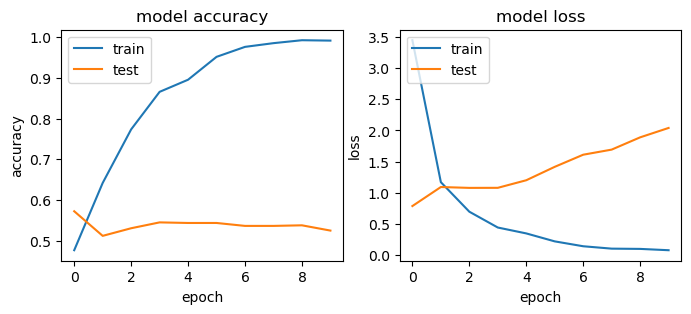

In [139]:
# Construct, compile, train and evaluate the ConvNet Model.
simpleRNNmodel = RNN("simpleRNN",simpleRNN_config, x_train, y_train, x_test, y_test) 

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, None, 128)         640000    
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 28)                4396      
                                                                 
 dropout_22 (Dropout)        (None, 28)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 29        
                                                                 
Total params: 644,425
Trainable params: 644,425
Non-trainable params: 0
_________________________________________________________________
The model took 13.573 seconds to train.

93/93 [==============================] - 1s 8ms/step
La matrice de confusion sur le jeu de test :
 [[  75 1284]
 [   7 1597]] 

L accuracy

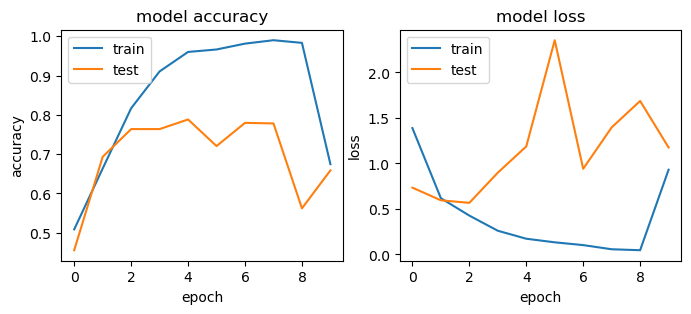

In [140]:
simpleLSTM_config ={
    "num_words": 5000 ,
    "mbed_size": 128,
    "LSTM_size": 28,
    "LSTM_Activation" : 'relu',
    "return_sequences": False,
    "LSTM_dropout_percentage" : 0.25,
    
    "compile_loss": 'binary_crossentropy',
    "compile_optimizer": 'adam',
    "compile_metrics": 'accuracy',

    "batch_size": 64,
    "num_epochs": 10,
    "fit_verbose": False,
    "validation_split": 0.2,
    
    "evaluate_verbose": True,
    "predict_verbose": True,  
}

# Construct, compile, train and evaluate the  Model.
simpleLSTMmodel = RNN("simpleLSTM",simpleLSTM_config, x_train, y_train, x_test, y_test) 

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, None, 128)         640000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 681,281
Trainable params: 681,281
Non-trainable params: 0
_________________________________________________________________
The model took 48.297 seconds to train.

93/93 [==============================] - 5s 28ms/step
La matrice de conf

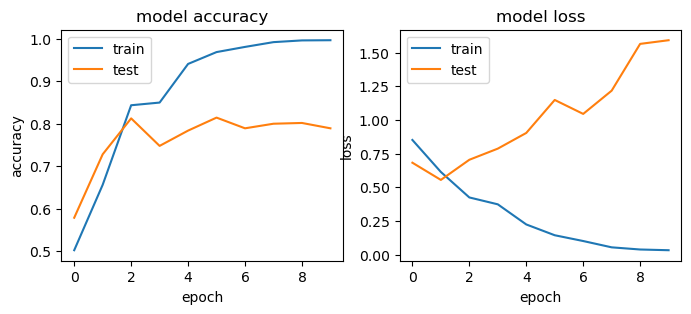

In [145]:
BI_LSTM_config ={
    "num_words": 5000 ,
    "mbed_size": 128,
    "BI_LSTM_size": 32,
    "return_sequences": False,
    "BI_LSTM_dropout_percentage" : 0.5,
    
    "compile_loss": 'binary_crossentropy',
    "compile_optimizer": 'adam',
    "compile_metrics": 'accuracy',

    "batch_size": 64,
    "num_epochs": 10,
    "fit_verbose": False,
    "validation_split": 0.2,
    
    "evaluate_verbose": True,
    "predict_verbose": True,  
}

# Construct, compile, train and evaluate the  Model.
BI_LSTMmodel = RNN("BI_LSTM",BI_LSTM_config, x_train, y_train, x_test, y_test) 